# 라이브러리

In [ ]:
#pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CSV 파일 읽기

In [ ]:
regular_season = pd.read_csv('/content/drive/MyDrive/프로젝트/KBO 타자 OPS 예측/Regular_Season_Batter.csv')
notpre_regular_season = pd.read_csv('/content/drive/MyDrive/프로젝트/KBO 타자 OPS 예측/Regular_Season_Batter.csv')
regular_season_day = pd.read_csv('/content/drive/MyDrive/프로젝트/KBO 타자 OPS 예측/Regular_Season_Batter_Day_by_Day_b4.csv')
pre_season = pd.read_csv('/content/drive/MyDrive/프로젝트/KBO 타자 OPS 예측/Pre_Season_Batter.csv')
submission = pd.read_csv('/content/drive/MyDrive/프로젝트/KBO 타자 OPS 예측/submission.csv')

# Regular_Season_Batter (정규 시즌) 전처리

## 1. 결측치 처리

### 1-1. 결측치 존재

In [ ]:
regular_season.isna().sum()

batter_id             0
batter_name           0
year                  0
team                  0
avg                  26
G                     0
AB                    0
R                     0
H                     0
2B                    0
3B                    0
HR                    0
TB                    0
RBI                   0
SB                    0
CS                    0
BB                    0
HBP                   0
SO                    0
GDP                   0
SLG                  26
OBP                  24
E                     0
height/weight       802
year_born             0
position            802
career                0
starting_salary    1067
OPS                  26
dtype: int64

### 1-2. avg(타율), SLG(장타율), OBP(출루율), OPS 
- 공통된 행에 결측치가 존재했고, 특징을 살펴보았을때 출전게임수가 상당히 적었음 
- 하사분위수를 확인하여 이를 기준으로 출전게임수가 28미만인 것은 이상치로 판단하여 제거하는 방법으로 해결 

In [ ]:
na_index = regular_season['avg'].isna()
regular_season[na_index]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
18,138,백승룡,2013,한화,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN,NaN
175,21,권용관,2000,LG,NaN,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,NaN,1976년 11월 19일,NaN,봉천초-강남중-성남고-LG-SK-LG,NaN,NaN
200,24,김강민,2002,SK,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,182cm/85kg,1982년 09월 13일,외야수(우투우타),본리초-대구중-경북고,11000만원,NaN
265,31,김동욱,2007,삼성,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,183cm/89kg,1988년 06월 24일,내야수(우투우타),신광초-경복중-대구고-삼성,13000만원,NaN
385,45,김성현,2007,SK,NaN,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,172cm/72kg,1987년 03월 09일,내야수(우투우타),송정동초-충장중-광주제일고-SK-상무,7000만원,NaN
663,97,마낙길,2015,NC,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,0,NaN,1989년 06월 22일,NaN,현산초(일산리틀)-언북중-충암고-경희대,NaN,NaN
931,132,박해민,2013,삼성,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,180cm/75kg,1990년 02월 24일,외야수(우투좌타),영중초-양천중-신일고-한양대,NaN,NaN
1049,151,손주인,2002,삼성,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,179cm/82kg,1983년 12월 01일,내야수(우투우타),광주서석초-진흥중-진흥고-삼성-경찰-삼성-LG,8000만원,NaN
1192,173,양영동,2006,삼성,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,NaN,1983년 07월 16일,NaN,수유초-청원중-청원고-홍익대-삼성-경찰-LG,NaN,NaN
1210,175,양종민,2013,롯데,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,181cm/81kg,1990년 10월 09일,내야수(우투우타),사당초-강남중-덕수고-(영남사이버대)-롯데,9000만원,NaN


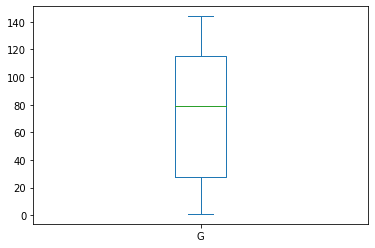

In [ ]:
regular_season['G'].plot(kind='box')

In [ ]:
regular_season['G'].describe()

count    2454.000000
mean       72.535045
std        45.093871
min         1.000000
25%        28.000000
50%        79.000000
75%       115.000000
max       144.000000
Name: G, dtype: float64

In [ ]:
# 출전 경기 28미만인 것 제거 
regular_season = regular_season[regular_season.G > 28].reset_index(drop=True)

### 1-3. height/weight(선수의 키/몸무게)
- OPS와 상관관계가 없었음 -> 제거

In [ ]:
regular_season = regular_season.drop(['height/weight'], axis=1)

In [ ]:
regular_season.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
2,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
3,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489
4,1,강경학,2017,한화,0.214,59,84,17,18,2,1,0,22,4,1,1,8,1,19,1,0.262,0.290,4,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.552


### 1-4. starting_salary(선수의 한국프로야구 입단연봉)
- OPS와 상관관계가 없었음 -> 제거

In [ ]:
regular_season = regular_season.drop(['starting_salary'], axis=1)

In [ ]:
regular_season.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,year_born,position,career,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),0.902
1,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.686
2,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.673
3,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.489
4,1,강경학,2017,한화,0.214,59,84,17,18,2,1,0,22,4,1,1,8,1,19,1,0.262,0.290,4,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.552


### 1-5. position(선수의 수비위치)
- None은 고유한 라벨로 인식
- 결측치 '없음'으로 대체

In [ ]:
regular_season['position'] = regular_season['position'].fillna('없음')

In [ ]:
regular_season['position'].unique()

array(['내야수(우투우타)', '내야수(우투좌타)', '없음', '포수(우투우타)', '외야수(우투좌타)',
       '외야수(우투양타)', '외야수(우투우타)', '외야수(좌투좌타)', '포수(우투좌타)', '내야수(좌투좌타)',
       '내야수(우투양타)'], dtype=object)

### 1-6. 전처리 결과

In [ ]:
regular_season.isna().sum()

batter_id      0
batter_name    0
year           0
team           0
avg            0
G              0
AB             0
R              0
H              0
2B             0
3B             0
HR             0
TB             0
RBI            0
SB             0
CS             0
BB             0
HBP            0
SO             0
GDP            0
SLG            0
OBP            0
E              0
year_born      0
position       0
career         0
OPS            0
dtype: int64

# pre_season (프리 시즌) 전처리

## 1. 결측치 처리

### 1-1. 결측치 존재

In [ ]:
pre_season.isna().sum()

batter_id            0
batter_name          0
year                 0
team                 0
avg                  0
G                    0
AB                   0
R                    0
H                    0
2B                   0
3B                   0
HR                   0
TB                   0
RBI                  0
SB                   0
CS                   0
BB                   0
HBP                  0
SO                   0
GDP                  0
SLG                 29
OBP                 25
E                    0
height/weight        0
year_born            0
position             0
career               0
starting_salary    214
OPS                 29
dtype: int64

### 1-2. SLG(장타율), OBP(출루율), OPS
- 공통된 행에 결측치가 존재했고, 특징을 살펴보았을때 출전게임수가 상당히 적었음 
- 하사분위수를 확인하여 이를 기준으로 출전게임수가 6미만인 것은 이상치로 판단하여 제거하는 방법으로 해결 

In [ ]:
na_index = pre_season['SLG'].isna()
pre_season[na_index]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
37,8,강상원,2016,한화,-,6,0,1,0,0,0,0,0,0,2,1,0,0,0,0,NaN,NaN,0,172cm/64kg,1997년 05월 05일,외야수(우투좌타),온양온천초-온양중-북일고,3000만원,NaN
74,24,김강민,2003,SK,-,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,182cm/85kg,1982년 09월 13일,외야수(우투우타),본리초-대구중-경북고,11000만원,NaN
80,24,김강민,2009,SK,-,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,182cm/85kg,1982년 09월 13일,외야수(우투우타),본리초-대구중-경북고,11000만원,NaN
90,101,문선재,2009,LG,-,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,NaN,1.0,0,184cm/80kg,1990년 05월 20일,외야수(우투우타),광주서림초-광주동성중-광주동성고-LG-상무,5000만원,NaN
99,31,김동욱,2008,삼성,-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,183cm/89kg,1988년 06월 24일,내야수(우투우타),신광초-경복중-대구고-삼성,13000만원,NaN
139,39,김민하,2014,롯데,-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,181cm/88kg,1989년 02월 25일,외야수(우투우타),승학초-부산대신중-경남고-중앙대-롯데-상무-롯데,NaN,NaN
142,40,김사훈,2012,롯데,-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,173cm/89kg,1987년 06월 18일,포수(우투우타),감천초-대신중-부산고-한민대-롯데-경찰,NaN,NaN
177,45,김성현,2007,SK,-,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,172cm/72kg,1987년 03월 09일,내야수(우투우타),송정동초-충장중-광주제일고-SK-상무,7000만원,NaN
187,46,김성훈,2016,삼성,-,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,172cm/68kg,1993년 10월 27일,내야수(우투좌타),길동초-건대부중-청원고-문화예술대,6000만원,NaN


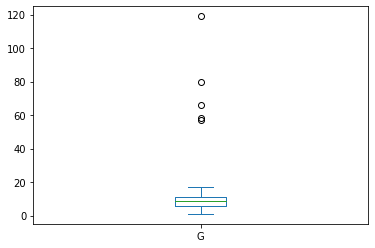

In [ ]:
pre_season['G'].plot(kind='box')

In [ ]:
pre_season['G'].describe()

count    1393.000000
mean        8.705671
std         5.562686
min         1.000000
25%         6.000000
50%         9.000000
75%        11.000000
max       119.000000
Name: G, dtype: float64

In [ ]:
# 출전 경기 6미만인 것 제거 
pre_season = pre_season[pre_season.G > 6].reset_index()

### 1-3. starting_salary(선수의 한국프로야구 입단연봉)
- OPS와 상관관계가 없었음 -> 제거

In [ ]:
pre_season = pre_season.drop(['starting_salary'], axis=1)

In [ ]:
regular_season.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,year_born,position,career,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),0.902
1,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.686
2,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.673
3,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.489
4,1,강경학,2017,한화,0.214,59,84,17,18,2,1,0,22,4,1,1,8,1,19,1,0.262,0.290,4,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,0.552


### 1-4. 전처리 결과

In [ ]:
pre_season.isna().sum()

index            0
batter_id        0
batter_name      0
year             0
team             0
avg              0
G                0
AB               0
R                0
H                0
2B               0
3B               0
HR               0
TB               0
RBI              0
SB               0
CS               0
BB               0
HBP              0
SO               0
GDP              0
SLG              0
OBP              0
E                0
height/weight    0
year_born        0
position         0
career           0
OPS              0
dtype: int64

# 전처리

## 1. One-Hot Encoding

In [ ]:
regular_season = pd.get_dummies(data = regular_season, columns = ['position'], prefix = 'position')

In [ ]:
regular_season.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,year_born,career,OPS,position_내야수(우투양타),position_내야수(우투우타),position_내야수(우투좌타),position_내야수(좌투좌타),position_없음,position_외야수(우투양타),position_외야수(우투우타),position_외야수(우투좌타),position_외야수(좌투좌타),position_포수(우투우타),position_포수(우투좌타)
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,1985년 04월 12일,쿠바 Ciego de Avila Maximo Gomez Baez(대),0.902,0,1,0,0,0,0,0,0,0,0,0
1,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,1992년 08월 11일,광주대성초-광주동성중-광주동성고,0.686,0,0,1,0,0,0,0,0,0,0,0
2,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,1992년 08월 11일,광주대성초-광주동성중-광주동성고,0.673,0,0,1,0,0,0,0,0,0,0,0
3,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,1992년 08월 11일,광주대성초-광주동성중-광주동성고,0.489,0,0,1,0,0,0,0,0,0,0,0
4,1,강경학,2017,한화,0.214,59,84,17,18,2,1,0,22,4,1,1,8,1,19,1,0.262,0.290,4,1992년 08월 11일,광주대성초-광주동성중-광주동성고,0.552,0,0,1,0,0,0,0,0,0,0,0


## 2. x_data, y_data 생성

In [ ]:
window_size = 1
target_size = 1 
x_col = ['avg', 'G', 'AB', 'R', 'H', '2B', 'HR', 'TB', 'RBI', 'BB', 'HBP', 'SO', 'GDP', 'SLG', 'OBP', 'OPS', 'position_내야수(우투양타)',	'position_내야수(우투우타)',	'position_내야수(우투좌타)',	'position_내야수(좌투좌타)',	'position_없음',	'position_외야수(우투양타)',	'position_외야수(우투우타)',	'position_외야수(우투좌타)',	'position_외야수(좌투좌타)',	'position_포수(우투우타)',	'position_포수(우투좌타)']
y_col = ['OPS']
batter_id_list = regular_season.batter_id.unique()

x_list = []
y_list = []

for batter_id in batter_id_list: 
  df_id = regular_season[regular_season.batter_id == batter_id].reset_index()
  x_df = df_id[x_col]
  y_df = df_id[y_col]

  if len(y_df) > window_size:
    for i in range(window_size, len(y_df)):
        x_list.append(np.array(x_df.iloc[i - window_size : i]))
        y_list.append(np.array(y_df.iloc[i : i + target_size ]))

x_data = np.array(x_list)
y_data = np.array(y_list)
x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1] * x_data.shape[2]))
y_data = np.reshape(y_data, (y_data.shape[0], y_data.shape[1]))

In [ ]:
x_data.shape

(1523, 27)

In [ ]:
y_data.shape

(1523, 1)

## 3. x_submission 생성

In [ ]:
#position 결측치 처리 
notpre_regular_season['position'] = notpre_regular_season['position'].fillna('없음')

#one-hot encoding
notpre_regular_season = pd.get_dummies(data = notpre_regular_season, columns = ['position'], prefix = 'position')

#2018년 시즌만 추출 
x_test = notpre_regular_season[notpre_regular_season.year == 2018]
x_test.reset_index(drop=True, inplace = True)

In [ ]:
x_test.isna().sum()

batter_id              0
batter_name            0
year                   0
team                   0
avg                    1
G                      0
AB                     0
R                      0
H                      0
2B                     0
3B                     0
HR                     0
TB                     0
RBI                    0
SB                     0
CS                     0
BB                     0
HBP                    0
SO                     0
GDP                    0
SLG                    1
OBP                    0
E                      0
height/weight          0
year_born              0
career                 0
starting_salary       45
OPS                    1
position_내야수(우투양타)     0
position_내야수(우투우타)     0
position_내야수(우투좌타)     0
position_내야수(좌투좌타)     0
position_없음            0
position_외야수(우투양타)     0
position_외야수(우투우타)     0
position_외야수(우투좌타)     0
position_외야수(좌투좌타)     0
position_포수(우투우타)      0
position_포수(우투좌타)      0
dtype: int64

In [ ]:
x_test[x_test.avg.isna()]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,career,starting_salary,OPS,position_내야수(우투양타),position_내야수(우투우타),position_내야수(우투좌타),position_내야수(좌투좌타),position_없음,position_외야수(우투양타),position_외야수(우투우타),position_외야수(우투좌타),position_외야수(좌투좌타),position_포수(우투우타),position_포수(우투좌타)
205,311,최윤석,2018,한화,NaN,2,0,1,0,0,0,0,0,0,0,0,2,0,0,0,NaN,1.0,0,175cm/75kg,1987년 03월 28일,화곡초-덕수중-성남고-홍익대-SK-한화-경찰,6000만원,NaN,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
notpre_regular_season[(notpre_regular_season.batter_id == 311) & (notpre_regular_season.year == 2017)]

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,career,starting_salary,OPS,position_내야수(우투양타),position_내야수(우투우타),position_내야수(우투좌타),position_내야수(좌투좌타),position_없음,position_외야수(우투양타),position_외야수(우투우타),position_외야수(우투좌타),position_외야수(좌투좌타),position_포수(우투우타),position_포수(우투좌타)
2244,311,최윤석,2017,한화,0.219,21,32,3,7,0,0,0,7,2,0,0,0,0,6,0,0.219,0.219,1,175cm/75kg,1987년 03월 28일,화곡초-덕수중-성남고-홍익대-SK-한화-경찰,6000만원,0.438,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# 이전 시즌 값으로 대체

x_test['avg'][205] = 0.219 
x_test['G'][205] = 21
x_test['AB'][205] = 32
x_test['R'][205] = 3
x_test['H'][205] = 	7
x_test['2B'][205] = 0
x_test['3B'][205] = 0
x_test['HR'][205] = 0
x_test['TB'][205] = 7
x_test['RBI'][205] = 2	
x_test['SB'][205] = 0
x_test['CS'][205] = 0
x_test['BB'][205] = 0
x_test['HBP'][205] = 0
x_test['SO'][205] = 6
x_test['GDP'][205] = 0
x_test['SLG'][205] = 0.219
x_test['OBP'][205] = 0.219	
x_test['E'][205] = 1
x_test['OPS'][205] = 0.438

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [ ]:
x_col = ['avg', 'G', 'AB', 'R', 'H', '2B', 'HR', 'TB', 'RBI', 'BB', 'HBP', 'SO', 'GDP', 'SLG', 'OBP', 'OPS', 'position_내야수(우투양타)',	'position_내야수(우투우타)',	'position_내야수(우투좌타)',	'position_내야수(좌투좌타)',	'position_없음',	'position_외야수(우투양타)',	'position_외야수(우투우타)',	'position_외야수(우투좌타)',	'position_외야수(좌투좌타)',	'position_포수(우투우타)',	'position_포수(우투좌타)']
x_list = []

for batter_id in submission.batter_id:
  x_list.append(np.array(x_test[x_test.batter_id == batter_id][x_col]))

x_submission = np.array(x_list)
x_submission = np.reshape(x_submission, (x_submission.shape[0], x_submission.shape[1] * x_submission.shape[2]))

In [ ]:
x_submission.shape

(220, 27)

# 모델링

## 1. K-Fold Cross-Validation

In [ ]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

## 2. Random Forest

In [ ]:
#모델 생성
model=RandomForestRegressor()

#최적화할 파라미터 범위 
rf_param = {'n_estimators': [25, 50, 100],
             'max_depth': [6, 8, 10],
             'min_samples_leaf' : [4, 8, 12],
             'min_samples_split' : [12, 16, 20]
             }

grid_rf = GridSearchCV(model, param_grid=rf_param, scoring = 'neg_root_mean_squared_error', cv=folds)
grid_rf.fit(x_data, y_data)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6, 8, 10],
                         'min_samples_leaf': [4, 8, 12],
                         'min_samples_split': [12, 16, 20],
                         'n_estimators': [25, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print('best params:\n', grid_rf.best_params_)
print('best score:', grid_rf.best_score_)

best params:
 {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 20, 'n_estimators': 100}
best score: -0.11335656841573487


## 3. XGBoost 

In [ ]:
#모델 생성
model=XGBRegressor()

#최적화할 파라미터 범위 
xgb_param = {'learning_rate': [0.01, 0.05, 0.1],
             'n_estimator': [25, 50, 100],
             'max_depth': [6, 8, 10]
             }

grid_xgb = GridSearchCV(model, param_grid=xgb_param, scoring = 'neg_root_mean_squared_error', cv=folds)
grid_xgb.fit(x_data, y_data)

[12:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 8, 10],
                         'n_estimator': [25, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print('best params:\n', grid_xgb.best_params_)
print('best score:', grid_xgb.best_score_)

best params:
 {'learning_rate': 0.05, 'max_depth': 6, 'n_estimator': 25}
best score: -0.11814855189359603


## 4. LGBM

In [ ]:
#모델 생성
model=LGBMRegressor()

#최적화할 파라미터 범위 
lgbm_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'n_estimator': [25, 50, 100],
}

grid_lgbm = GridSearchCV(model, param_grid=lgbm_params, scoring = 'neg_root_mean_squared_error', cv=folds)
grid_lgbm.fit(x_data, y_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 8, 10],
                         'n_estimator': [25, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print('best params:\n', grid_lgbm.best_params_)
print('best score:', grid_lgbm.best_score_)

best params:
 {'learning_rate': 0.05, 'max_depth': 6, 'n_estimator': 25}
best score: -0.1147742646726424


## 5. CatBoost

In [ ]:
#모델 생성
model=CatBoostRegressor()

#최적화할 파라미터 범위 
cb_params = {'depth' : [6, 8, 10],
             'learning_rate' : [0.01, 0.05, 0.1],
             'iterations' : [25, 50, 100]
            }


grid_cb = GridSearchCV(model, param_grid=cb_params, scoring = 'neg_root_mean_squared_error', cv=folds)
grid_cb.fit(x_data, y_data)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0:	learn: 0.1394097	total: 7.84ms	remaining: 188ms
1:	learn: 0.1355555	total: 15.6ms	remaining: 180ms
2:	learn: 0.1321673	total: 23.5ms	remaining: 172ms
3:	learn: 0.1288354	total: 31.5ms	remaining: 166ms
4:	learn: 0.1260925	total: 39.2ms	remaining: 157ms
5:	learn: 0.1239827	total: 50.8ms	remaining: 161ms
6:	learn: 0.1219186	total: 62ms	remaining: 159ms
7:	learn: 0.1203120	total: 69.9ms	remaining: 149ms
8:	learn: 0.1185108	total: 77.5ms	remaining: 138ms
9:	learn: 0.1171522	total: 85.5ms	remaining: 128ms
10:	learn: 0.1158608	total: 98.8ms	remaining: 126ms
11:	learn: 0.1148855	total: 107ms	remaining: 116ms
12:	learn: 0.1139669	total: 115ms	remaining: 106ms
13:	learn: 0.1130862	total: 122ms	remaining: 96.1ms
14:	learn: 0.1122766	total: 131ms	remaining: 87.1ms
15:	learn: 0.1116364	total: 139ms	remaining: 77.9ms
16:	learn: 0.1107722	total: 146ms	remaining: 68.9ms
17:	learn: 0.1102740	total: 154ms	remaining: 60ms
18:	learn: 0.1093685	total: 162ms	remaining:

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f43d6cf3550>,
             param_grid={'depth': [6, 8, 10], 'iterations': [25, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print('best params:\n', grid_cb.best_params_)
print('best score:', grid_cb.best_score_)

best params:
 {'depth': 6, 'iterations': 100, 'learning_rate': 0.05}
best score: -0.1131794280637672


## 6. Stacking ensemble


In [ ]:
estimators = [
            ('RF', RandomForestRegressor()),
            ('XGB', XGBRegressor()),
            ('LGBM',LGBMRegressor()),
            ('CB',CatBoostRegressor())
            ]

stacking_reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

params = {'RF__max_depth': [10],
          'RF__min_samples_leaf' : [12],
          'RF__min_samples_split' : [16],
          'RF__n_estimators' : [100],
          'XGB__learning_rate' : [0.05],
          'XGB__max_depth' : [6],
          'XGB__n_estimator' : [25],
          'LGBM__learning_rate' : [0.05],
          'LGBM__max_depth' : [6],
          'LGBM__n_estimator' : [25],
          'LGBM__num_leaves' : [7],
          'CB__depth' : [6],
          'CB__iterations' : [100],
          'CB__learning_rate' : [0.05]
          }

stacking_grid = GridSearchCV(estimator=stacking_reg, param_grid=params, scoring = 'neg_root_mean_squared_error', cv=folds)
stacking_grid.fit(x_data, y_data)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 0.1407253	total: 2.85ms	remaining: 283ms
1:	learn: 0.1384142	total: 5.68ms	remaining: 278ms
2:	learn: 0.1364020	total: 10.6ms	remaining: 343ms
3:	learn: 0.1345159	total: 13.3ms	remaining: 319ms
4:	learn: 0.1326231	total: 16.8ms	remaining: 320ms
5:	learn: 0.1310930	total: 20.5ms	remaining: 321ms
6:	learn: 0.1295292	total: 23.1ms	remaining: 307ms
7:	learn: 0.1281237	total: 27.2ms	remaining: 312ms
8:	learn: 0.1267401	total: 29.9ms	remaining: 302ms
9:	learn: 0.1254774	total: 47.8ms	remaining: 431ms
10:	learn: 0.1241589	total: 51.2ms	remaining: 415ms
11:	learn: 0.1230951	total: 54.7ms	remaining: 401ms
12:	learn: 0.1220668	total: 58.5ms	remaining: 391ms
13:	learn: 0.1211418	total: 61.3ms	remaining: 376ms
14:	learn: 0.1202914	total: 65.7ms	remaining: 372ms
15:	learn: 0.1194990	total: 68.8ms	remaining: 361ms
16:	learn: 0.1186663	total: 71.7ms	remaining: 350ms

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 0.1413050	total: 7.16ms	remaining: 709ms
1:	learn: 0.1390589	total: 14.5ms	remaining: 711ms
2:	learn: 0.1371208	total: 17.3ms	remaining: 558ms
3:	learn: 0.1350838	total: 20ms	remaining: 481ms
4:	learn: 0.1331734	total: 22.8ms	remaining: 434ms
5:	learn: 0.1316244	total: 25.6ms	remaining: 401ms
6:	learn: 0.1301065	total: 28.5ms	remaining: 378ms
7:	learn: 0.1289082	total: 31.5ms	remaining: 363ms
8:	learn: 0.1274368	total: 34.5ms	remaining: 349ms
9:	learn: 0.1262374	total: 37.4ms	remaining: 336ms
10:	learn: 0.1250561	total: 40.2ms	remaining: 326ms
11:	learn: 0.1240029	total: 43.1ms	remaining: 316ms
12:	learn: 0.1229686	total: 46.1ms	remaining: 308ms
13:	learn: 0.1219705	total: 49.1ms	remaining: 301ms
14:	learn: 0.1210500	total: 51.9ms	remaining: 294ms
15:	learn: 0.1202117	total: 54.9ms	remaining: 288ms
16:	learn: 0.1193197	total: 57.9ms	remaining: 283ms
1

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 0.1405551	total: 2.96ms	remaining: 293ms
1:	learn: 0.1382571	total: 6.34ms	remaining: 311ms
2:	learn: 0.1362281	total: 9.39ms	remaining: 304ms
3:	learn: 0.1342486	total: 12.3ms	remaining: 295ms
4:	learn: 0.1323572	total: 15.3ms	remaining: 290ms
5:	learn: 0.1308160	total: 18.3ms	remaining: 287ms
6:	learn: 0.1291877	total: 21.3ms	remaining: 283ms
7:	learn: 0.1277669	total: 24.1ms	remaining: 277ms
8:	learn: 0.1264117	total: 27ms	remaining: 273ms
9:	learn: 0.1251055	total: 29.9ms	remaining: 269ms
10:	learn: 0.1238879	total: 33ms	remaining: 267ms
11:	learn: 0.1228212	total: 35.9ms	remaining: 263ms
12:	learn: 0.1218713	total: 38.5ms	remaining: 258ms
13:	learn: 0.1209846	total: 41.5ms	remaining: 255ms
14:	learn: 0.1199725	total: 44.4ms	remaining: 252ms
15:	learn: 0.1191154	total: 47.1ms	remaining: 247ms
16:	learn: 0.1182123	total: 50.1ms	remaining: 245ms
17:

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 0.1402387	total: 2.9ms	remaining: 287ms
1:	learn: 0.1380712	total: 6.41ms	remaining: 314ms
2:	learn: 0.1360712	total: 9.24ms	remaining: 299ms
3:	learn: 0.1342501	total: 12.2ms	remaining: 292ms
4:	learn: 0.1325114	total: 15.1ms	remaining: 286ms
5:	learn: 0.1310592	total: 18ms	remaining: 282ms
6:	learn: 0.1295002	total: 21.2ms	remaining: 282ms
7:	learn: 0.1283551	total: 24.1ms	remaining: 277ms
8:	learn: 0.1269804	total: 27.1ms	remaining: 274ms
9:	learn: 0.1257906	total: 29.9ms	remaining: 269ms
10:	learn: 0.1247260	total: 32.8ms	remaining: 265ms
11:	learn: 0.1237614	total: 35.7ms	remaining: 262ms
12:	learn: 0.1228512	total: 38.7ms	remaining: 259ms
13:	learn: 0.1220353	total: 41.6ms	remaining: 256ms
14:	learn: 0.1211566	total: 44.4ms	remaining: 252ms
15:	learn: 0.1204668	total: 47.4ms	remaining: 249ms
16:	learn: 0.1195822	total: 50.9ms	remaining: 249ms
17

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 0.1418254	total: 3ms	remaining: 297ms
1:	learn: 0.1395735	total: 5.79ms	remaining: 284ms
2:	learn: 0.1375809	total: 8.9ms	remaining: 288ms
3:	learn: 0.1356743	total: 11.8ms	remaining: 284ms
4:	learn: 0.1339311	total: 15ms	remaining: 285ms
5:	learn: 0.1324271	total: 18ms	remaining: 282ms
6:	learn: 0.1307868	total: 20.9ms	remaining: 278ms
7:	learn: 0.1294415	total: 23.9ms	remaining: 274ms
8:	learn: 0.1282772	total: 26.8ms	remaining: 271ms
9:	learn: 0.1270816	total: 29.6ms	remaining: 267ms
10:	learn: 0.1258897	total: 32.4ms	remaining: 262ms
11:	learn: 0.1249704	total: 35.2ms	remaining: 258ms
12:	learn: 0.1239039	total: 38.1ms	remaining: 255ms
13:	learn: 0.1229663	total: 41ms	remaining: 252ms
14:	learn: 0.1221802	total: 43.9ms	remaining: 249ms
15:	learn: 0.1213898	total: 46.7ms	remaining: 245ms
16:	learn: 0.1204421	total: 49.7ms	remaining: 242ms
17:	learn

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 0.1409814	total: 3.13ms	remaining: 310ms
1:	learn: 0.1386862	total: 7.06ms	remaining: 346ms
2:	learn: 0.1366168	total: 10.3ms	remaining: 333ms
3:	learn: 0.1346810	total: 13.4ms	remaining: 322ms
4:	learn: 0.1329872	total: 16.6ms	remaining: 315ms
5:	learn: 0.1315193	total: 19.6ms	remaining: 307ms
6:	learn: 0.1299108	total: 22.6ms	remaining: 301ms
7:	learn: 0.1285780	total: 25.8ms	remaining: 296ms
8:	learn: 0.1272762	total: 28.8ms	remaining: 291ms
9:	learn: 0.1260302	total: 31.9ms	remaining: 287ms
10:	learn: 0.1248974	total: 34.8ms	remaining: 282ms
11:	learn: 0.1239158	total: 37.8ms	remaining: 277ms
12:	learn: 0.1229194	total: 40.9ms	remaining: 274ms
13:	learn: 0.1220205	total: 44ms	remaining: 270ms
14:	learn: 0.1211467	total: 46.9ms	remaining: 266ms
15:	learn: 0.1202903	total: 49.9ms	remaining: 262ms
16:	learn: 0.1195048	total: 52.9ms	remaining: 258ms
1

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=StackingRegressor(estimators=[('RF',
                                                      RandomForestRegressor()),
                                                     ('XGB', XGBRegressor()),
                                                     ('LGBM', LGBMRegressor()),
                                                     ('CB',
                                                      <catboost.core.CatBoostRegressor object at 0x7f43d6c79350>)],
                                         final_estimator=LinearRegression()),
             param_grid={'CB__depth': [6], 'CB__iterations': [100],
                         'CB__learning_rate': [0.05],
                         'LGBM__learning_rate': [0.05], 'LGBM__max_depth': [6],
                         'LGBM__n_estimator': [25], 'LGBM__num_leaves': [7],
                         'RF__max_depth': [10], 'RF__min_samples_leaf': [12],
                        

In [ ]:
print('best params:\n', stacking_grid.best_params_)
print('best score:', stacking_grid.best_score_)

best params:
 {'CB__depth': 6, 'CB__iterations': 100, 'CB__learning_rate': 0.05, 'LGBM__learning_rate': 0.05, 'LGBM__max_depth': 6, 'LGBM__n_estimator': 25, 'LGBM__num_leaves': 7, 'RF__max_depth': 10, 'RF__min_samples_leaf': 12, 'RF__min_samples_split': 16, 'RF__n_estimators': 100, 'XGB__learning_rate': 0.05, 'XGB__max_depth': 6, 'XGB__n_estimator': 25}
best score: -0.1134122356164922


# 최종 예측 

In [ ]:
submission['ops'] =  stacking_grid.predict(x_submission)

In [ ]:
submission

,batter_id,batter_name,ops
0,1,강경학,0.742386
1,2,강구성,0.654647
2,3,강민국,0.585517
3,4,강민호,0.808794
4,5,강백호,0.925415
...,...,...,...
215,337,홍재호,0.698442
216,338,홍창기,0.633565
217,341,황윤호,0.585687
218,342,황재균,0.919230
